# Index
1. Reading the data
2. Exploratory Data Analysis
    1. Target Variable Distrubution (check if its inbalanced)
    2. Distribution of features
    3. Missing values of features
    4. Correlation of features
    5. Description of the data (df.describe())
    6. Outlier detection (remove nonsensical data / boxplots) / (create a function to remove outliers)
    7. Check distinct values in features / check ordinal values
3. Feature Engineering
    1. Missing value imputation (mode, median, mean, k-NN, SMOTE etc.)
    2. Create new features using arithmetical transformations of existing features.
    3. PCA 
    4. Try few models to decide feature importances to reduce features. (target shuffling)
    5. Add new features using outside data sources.
    6. Train, Test, Validation split (use validation for hyperparameter tuning)
4. Modeling (find important features using models, then return to feature engineering)
    1. Linear Regression (remove multicolonarity, then check coefficient of features to determine their importance) (correlation matrix 85%>)
    2. Decision Tree
    3. Adaboost
    4. Random Forest (entropy)
    5. XGBoost
    6. LightGBM
    7. Gradient Boosting
    8. Ensemble Learning
5. Hyperparameter Tuning
    1. Optuna

# Dependencies & Functions

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model as lin 
from sklearn import preprocessing as pre
from sklearn import metrics as met
from sklearn import model_selection as mod
from sklearn import pipeline as pip
from sklearn import datasets as dat
from sklearn import tree
from sklearn import preprocessing as pre
from sklearn import ensemble as ens
from sklearn import svm
from sklearn import decomposition as dec
from sklearn import manifold as man
from sklearn import impute as imp
from sklearn import compose as com

from imblearn import pipeline as imbPip # imblearn pipeline
from imblearn import under_sampling as und
from imblearn import over_sampling as ove

import xgboost as xgb

import seaborn as sns

from pandas_profiling import ProfileReport as p_rep

import lightgbm as lgbm

import datetime as dtime

np.set_printoptions(suppress=True) 

import warnings
warnings.filterwarnings("ignore")

# Reading the Data

In [2]:
# Variables
Data_Path = "Data/train.xlsx"
Target = "is claim"

In [3]:
#df = pd.read_csv('Data_Path')
df = pd.read_excel(Data_Path)

# Explorary Data Analysis

In [4]:
df_profile = p_rep(df, title="Profiling Report")

# Get current time
now = dtime.datetime.now()

# Format time as string
timestamp = now.strftime('%Y%m%d%H%M')

# Create filename
filename = f'data_report_{timestamp}.html'

# Save file
df_profile.to_file(filename)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Target Value Distribution

In [5]:
def print_data_distribution(df, col):
  # Get value counts
  value_counts = df[col].value_counts()
  
  # Get total number of rows
  n = df.shape[0]
  
  # Create empty list to store results
  results = []
  
  # Iterate through value counts
  for value, count in value_counts.items():
    # Calculate percentage
    pct = 100 * count / n
    
    # Append result to list
    results.append([value, count, pct])
  
  # Create dataframe from results
  df_results = pd.DataFrame(results, columns=[col, 'Count', 'Percentage'])
  
  # Print results
  print(df_results)

In [6]:
print_data_distribution(df, Target)

   is claim  Count  Percentage
0         0  40804   93.604331
1         1   2788    6.395669


## Distribution of Features

In [7]:
def explore_features(df):
  # Get list of columns
  columns = df.columns
  
  # Create empty list to store results
  results = []
  
  # Iterate through columns
  for col in columns:
    # Get data type
    dtype = df[col].dtype
    
    # Get number of unique values
    unique_values = df[col].nunique()
    
    # Get skewness (for numeric columns only)
    if df[col].dtype in ['int64', 'float64']:
      skewness = df[col].skew()
    else:
      skewness = 'N/A'
    
    # Get number of missing values
    missing_values = df[col].isnull().sum()
    
    # Get percentage of missing values
    pct_missing = 100 * missing_values / df.shape[0]
    
    # Append results to list
    results.append([col, dtype, unique_values, skewness, missing_values, pct_missing])
  
  # Create dataframe from results
  df_results = pd.DataFrame(results, columns=['Column', 'Data Type', 'Unique Values',
                                             'Skewness', 'Missing Values', '% Missing'])
  
  # Sort dataframe by data type
  df_results = df_results.sort_values('Data Type')
    
  # Print results
  return df_results



In [8]:
explore_features(df)

,Column,Data Type,Unique Values,Skewness,Missing Values,% Missing
0,ID,int64,43592,0.0,0,0.000000
43,area danger level,int64,5,0.008684,0,0.000000
44,is claim,int64,2,3.564377,0,0.000000
3,policyholder age,float64,43511,0.638718,81,0.185814
29,time period,float64,43510,0.055738,82,0.188108
1,ncap rating,float64,5,0.078467,99,0.227106
21,cylinder,float64,2,-0.536614,97,0.222518
20,manufacturer,float64,5,1.189586,87,0.199578
18,engine volume,float64,9,-0.113076,103,0.236282
33,length,float64,9,0.139318,88,0.201872


## Missing Values

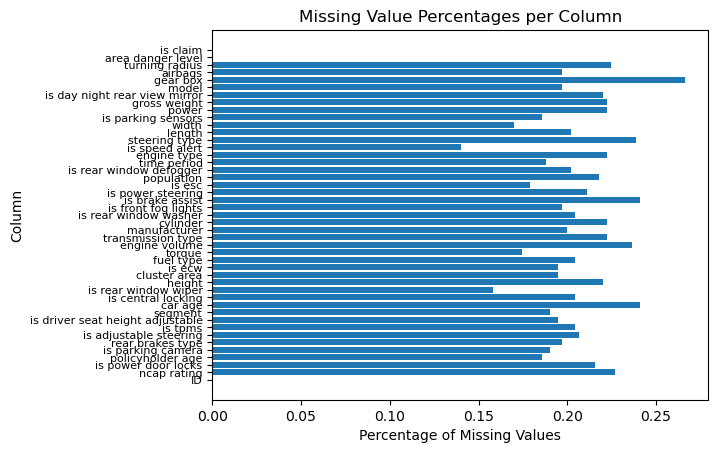

<Figure size 1600x1200 with 0 Axes>

In [9]:
# Get number of missing values for each column
missing_values = df.isnull().sum()

# Calculate missing value percentages
missing_pct = 100 * missing_values / df.shape[0]

# Plot missing value percentages as a horizontal bar plot
plt.barh(missing_pct.index, missing_pct.values)

# Add labels and show plot
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Column')
plt.title('Missing Value Percentages per Column')
plt.yticks(fontsize=8)
plt.figure(figsize=(16, 12))
plt.show()

## Correlation of Features